# Huấn luyện nối tiếp và cập nhật mô hình XGboost

### BS. Lê Ngọc Khả Nhi

# Giới thiệu: 

Thông thường, mô hình Machine learning được huấn luyện 1 lần duy nhất sử dụng toàn bộ dữ liệu trong tập Train. Tuy nhiên trong một số hoàn cảnh, dữ liệu trong lần thí nghiệm đầu tiên có thể chưa đủ lớn, và người ta tiếp tục tích lũy thêm dữ liệu mới theo thời gian. Lúc này có thể ta muốn huấn luyện lại mô hình cũ một cách định kì từ dữ liệu mới. Ta có thể làm theo 2 cách: (1) Huấn luyện một phiên bản mô hình hoàn toàn mới trên toàn bộ dữ liệu tích lũy (cũ và mới), hoặc (2) Cập nhật phiên bản mô hình cũ với duy nhất gói dữ liệu mới. Việc huấn luyện tiếp nối và cập nhật này là khả thi với mô hình Deep learning, nhưng ít phổ biến với những algorithm machine learning khác. Điều thú vị là alorithm XGboost cho phép làm điều này.


# Mô tả thí nghiệm

Trong bài thực hành hôm nay, Nhi thực hiện 1 thí nghiệm huấn luyện nối tiếp cho một mô hình XGBoost regression như sau:

Một bộ dữ liệu rất lớn được chia thành Trainset (n=66078) và test set (n=7343). Mục tiêu là ước tính điểm số hài lòng của sinh viên dành cho giảng viên. 

1) Đầu tiên, chúng ta dựng một mô hình XGboost trên toàn bộ Trainset, 

2) Tiếp theo, ta chia nhỏ Trainset thành 66 phần có kích thước bằng nhau là n=1000, và lần lượt huấn luyện 66 phiên bản mô hình XGBoost theo nguyên tắc như sau: Phiên bản đấu tiến (0) chỉ sử dụng 1000 instances đầu tiên, phiên bản tiếp theo là một sự tiếp nối và cập nhật của phiên bản cũ, dựa trên 1000 instances mới; cứ tiếp tục như vậy cho đến phiên bản thứ 65. 

Độ chính xác của mỗi phiên bản sẽ được theo dõi dựa trên cùng test set (n = 7343), và mỗi phiên bản mô hình được lưu lại một cách độc lập.

## Chuẩn bị dữ liệu

In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/lme4/InstEval.csv', index_col=0)

df.columns = ["Student","Lecturer","Stud_Age","Lect_Age","Service","Dept","Score"]

df["Student"] = df["Student"].astype('category')
df["Lecturer"] = df["Lecturer"].astype('category')
df["Dept"] = df["Dept"].astype('category')

df["Stud_Age"] = df["Stud_Age"].astype('object')
df["Lect_Age"] = df["Lect_Age"].astype('object')
df["Service"] = df["Service"].astype('object')

df["Score"] = df["Score"].astype('float')

df.info()

df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73421 entries, 1 to 73421
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Student   73421 non-null  category
 1   Lecturer  73421 non-null  category
 2   Stud_Age  73421 non-null  object  
 3   Lect_Age  73421 non-null  object  
 4   Service   73421 non-null  object  
 5   Dept      73421 non-null  category
 6   Score     73421 non-null  float64 
dtypes: category(3), float64(1), object(3)
memory usage: 3.3+ MB


,Student,Lecturer,Stud_Age,Lect_Age,Service,Dept,Score
1,1,1002,2,2,0,2,5.0
2,1,1050,2,1,1,6,2.0
3,1,1582,2,2,0,2,5.0
4,1,2050,2,2,1,3,3.0
5,2,115,2,1,0,5,2.0
6,2,756,2,1,0,5,4.0
7,3,7,2,1,1,11,4.0
8,3,13,2,1,0,10,5.0
9,3,36,2,1,0,10,5.0
10,3,140,2,1,0,10,4.0


In [3]:
fe_form = 'Score ~ Stud_Age*Lect_Age*Service*Service*Dept'

Y, X = dmatrices(fe_form, data=df, return_type='matrix')

X = np.asarray(X)
Y = np.asarray(Y).flatten()

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.1)

Kích thước Train set và test set:

In [7]:
print(X_train.shape, X_test.shape)

(66078, 672) (7343, 672)


Chuẩn bị hàm tính median của sai số dự báo:

In [8]:
def median_error(mod = None, x = None, y = None):
    return np.median(mod.predict(x) - y)

In [9]:
mod = XGBRegressor(learning_rate = 0.01, # or eta
                   booster='dart',
                   max_depth = 7,
                   tree_method = "gpu_hist",
                   grow_policy = "lossguide",
                   predictor = 'gpu_predictor')

## Mô hình dùng toàn bộ Trainset:

Mô hình mod_pool dùng toàn bộ 66078 instances của train set, khi kiểm tra nó có median error = -0.827

In [10]:
mod_pool = mod.fit(X_train,Y_train)

In [11]:
median_error(mod_pool,X_test,Y_test)

-0.8271408081054688

## Huấn luyện nối tiếp:

Quy trình huấn luyện nối tiếp diễn ra như sau:
    
Trước hết ta phải có 1 mô hình ban đầu, ở đây đặt tên là mod, được huấn luyện trên 1000 instances đầu tiên của train_set, sau khi làm xong, ta dùng method save_model để lưu object mô hình thành 1 file có tên là mod_0, đây là 1 phiên bản tạm thời.

Mô hình mod_0 cơ bản này có median error = -0.807 (Như vậy cho thấy chỉ dùng 1 phần rất nhỏ của Trainset nhưng độ chính xác của mô hình lại gần bằng với khi dùng toàn bộ trainset).

In [14]:
mod = XGBRegressor(learning_rate = 0.01, # or eta
                   booster='dart',
                   max_depth = 7,
                   tree_method = "gpu_hist",
                   grow_policy = "lossguide",
                   predictor = 'gpu_predictor')

n = 1000
dx = X_train[0:n]
dy = Y_train[0:n]

mod.fit(dx, dy)
mod.save_model(f'mod_{0}')

median_error(mod,X_test,Y_test)

-0.8072412014007568

Tiếp theo, giả sử sau 1 thời gian ta có thêm 1000 dữ liệu mới, ta huấn luyện một mô hình mod_1 trên 1000 instances mới này, nhưng để kích hoạt cơ chế huấn luyện tiếp nối, ta thêm argument : xgb_model = 'tên của file phiên bản mô hình cũ' trong method fit(). Lúc này XGboost sẽ tải mô hình cũ và cập nhật quy luật các cây quyết định bên trong dựa vào dữ liệu mới.

Nhi dùng 1 vòng lặp để lặp lại quy trình này 65 lần, cho đến khi dùng hết 66000 instances trong train set, mỗi lần như vậy đều sao lưu 1 phiên bản mô hình, và dùng chính phiên bản này để tiếp tục train cho lượt tiếp theo.

In [16]:
i = 1
start = n

perf = [median_error(mod,X_test,Y_test)]

while start + n < len(X_train):
    print(f'{start} {start + n}')
    
    dx = X_train[start:start+n]
    dy = Y_train[start:start+n]

    mod.fit(dx, dy, xgb_model=f'mod_{i-1}')
    mod.save_model(f'mod_{i}')
    
    temp_perf = median_error(mod,X_test,Y_test)
    
    print(f'Mô hình {i}, median error = {temp_perf}')
    
    perf += [temp_perf]
    start += n
    
    i += 1

1000 2000
Mô hình 1, median error = -0.16720247268676758
2000 3000
Mô hình 2, median error = 0.013847112655639648
3000 4000
Mô hình 3, median error = 0.06371545791625977
4000 5000
Mô hình 4, median error = 0.03848075866699219
5000 6000
Mô hình 5, median error = 0.07689261436462402
6000 7000
Mô hình 6, median error = 0.0638270378112793
7000 8000
Mô hình 7, median error = 0.06176877021789551
8000 9000
Mô hình 8, median error = 0.07783174514770508
9000 10000
Mô hình 9, median error = 0.09695148468017578
10000 11000
Mô hình 10, median error = 0.0018672943115234375
11000 12000
Mô hình 11, median error = -0.02926802635192871
12000 13000
Mô hình 12, median error = -0.030432939529418945
13000 14000
Mô hình 13, median error = -0.04589128494262695
14000 15000
Mô hình 14, median error = -0.006506681442260742
15000 16000
Mô hình 15, median error = -0.005151987075805664
16000 17000
Mô hình 16, median error = -0.028557300567626953
17000 18000
Mô hình 17, median error = -0.0167694091796875
18000 1900

Ta thấy hiện tượng thú vị, đó là ngay từ lượt đầu tiên, median error của mô hình đã tốt hơn so với mô hình gốc (và thậm chí tốt hơn mô hình dùng toàn bộ trainset); sau đó kể từ lượt thứ 10, median error đạt trạng thái khá tốt, rất gần với 0, qua 50 lượt tiếp theo median error có tăng và giảm, có khi tốt hơn, có khi tệ hơn, nhưng vẫn gần với 0.

Để tải 1 phiên bản mô hình, ta dùng method load_model từ 1 object XGboost.

Đây là phân bố của prediction của 66 mô hình, cho thấy kể từ 4000 instances trở lên, hình ảnh phân bố trở nên đồng nhất. 

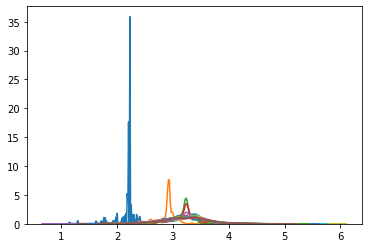

In [17]:
mod = XGBRegressor(learning_rate = 0.01, # or eta
                   booster='dart',
                   max_depth = 7,
                   tree_method = "gpu_hist",
                   grow_policy = "lossguide",
                   predictor = 'gpu_predictor')

for i in range(66):
    mod.load_model(f'mod_{i}')
    sns.kdeplot(mod.predict(X_test))

Diễn tiến Median error qua 66 lượt huấn luyện tiếp nối như sau:

Text(0, 0.5, 'Median error')

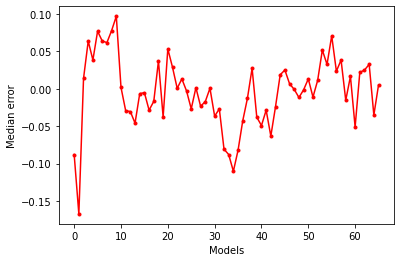

In [18]:
plt.plot(perf, '.-', c ='red')
plt.xlabel('Models')
plt.ylabel('Median error')

Tuy nhiên, độ chính xác cao có cái giá của nó: ta thấy kích thước của các phiên bản mô hình tăng một cách tuyến tính sau mỗi lượt huấn luyện, từ 121 Kb cho mô hình mod_0 tăng lên đến 9.43 Mb cho mô hình mod_65; như vậy huấn luyện nối tiếp làm tăng kích thước mô hình.

Text(0, 0.5, 'Size (Mb)')

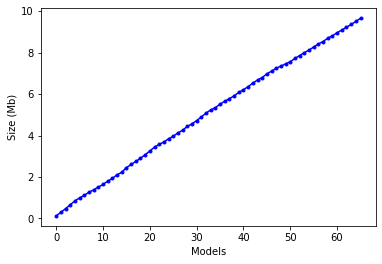

In [19]:
import os

sizes = []

for i in range(66):
    sizes += [os.path.getsize('./'+ f'mod_{i}')*1e-6]
    
plt.plot(sizes, '.-', c ='blue')
plt.xlabel('Models')
plt.ylabel('Size (Mb)')

# Bàn luận

Dựa vào kết quả thí nghiệm, có thể rút ra một số nhận định:

Algorithm XGBoost cho phép huấn luyện tiếp nối trên các phiên bản tạm thời, khả năng này là một ưu thế đáng kể so với những algorithm machine learning cổ điển khác.

Việc huấn luyện tiếp nối có thể hữu ích trong 1 số hoàn cảnh như: Dữ liệu cần thời gian để thu thập, người dùng đặt ra mục tiêu bảo trì, cập nhật mô hình theo thời gian, dữ liệu quá lớn không thể tải vào bộ nhớ trong 1 lần duy nhất...

Huấn luyện nối tiếp sẽ làm kích thước mô hình ngày càng lớn, đây là một nhược điểm, 

Cần cân nhắc giữa việc huấn luyện 1 mô hình hoàn toàn mới có kích thước nhỏ và cập nhật liên tục 1 mô hình cũ; vì không phải khi nào hiệu quả của huấn luyện tiếp nối cũng tốt hơn.

Bài thực hành tạm dừng và hẹn gặp lại lần sau.